In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

df = pd.read_csv('stud_math.csv')

# Цели
Основная цель - подготовить данные для работы модели. Для того, чтобы её достичь были выполнены следующие цели:
1. Очистка количественных признаков от выбросов и невалидных данных
2. Удаление шумовых количественных признаков
2. Удаление шумовых категориальных признаков

# Очистка количественных признаков

После загрузки датасета пройдёмся сперва по всем количественным признакам и удалим из датасета строки, содержащие пустые значения

In [114]:
def delete_nan_from_df(df):
    df2 = df.copy()
    for column in df.columns:
        if df.dtypes[column] != 'O':
            print('Удалено строк из столбца {}: {}'.format(column, df[column].isna().sum()))
            df2 = df2[~df2[column].isna()]
    return df2


df_clean = delete_nan_from_df(df)


Удалено строк из столбца age: 0
Удалено строк из столбца Medu: 3
Удалено строк из столбца Fedu: 24
Удалено строк из столбца traveltime: 28
Удалено строк из столбца studytime: 7
Удалено строк из столбца failures: 22
Удалено строк из столбца studytime, granular: 7
Удалено строк из столбца famrel: 27
Удалено строк из столбца freetime: 11
Удалено строк из столбца goout: 8
Удалено строк из столбца health: 15
Удалено строк из столбца absences: 12
Удалено строк из столбца score: 6


Далее детально посмотрим на каждый из количественных признаков в поисках выбросов

## age

In [115]:
df_clean.age.value_counts()

16    75
17    62
18    56
15    50
19    15
20     3
22     1
21     1
Name: age, dtype: int64

По легенде наш датасет содержит данные о школьниках от 15 до 22 лет. Следовательно, выбросы в данном столбце отсутствуют

## Medu

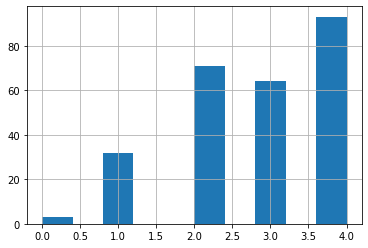

In [116]:
df_clean.Medu.hist()

Следуя здравому смыслу, кажется, что выбросов здесь нет и набор данных вполне реалистичный - матерей, которые не имеют образования вовсе, или которые окончили лишь несколько классов меньшинство.

## Fedu

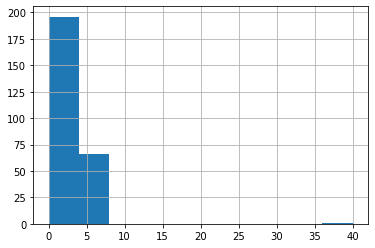

In [117]:
df_clean.Fedu.hist()

Очевидно, что в данном столбце есть выброс, поскольку по легенде этот столбец не может содержать значения выше 4.
Удаляем из датасета строку с выбросом.

In [118]:
df_clean = df_clean[df_clean.Fedu<=4]

Смотрим на распределение признака вновь, чтобы убедиться, что мы не пропустили иные выбросы

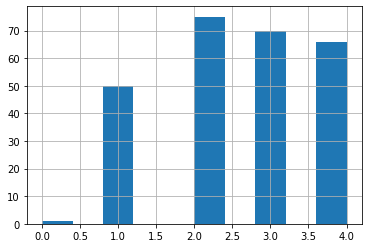

In [119]:
df_clean.Fedu.hist()

Выглядит вполне реалистично. Двигаемся дальше

## traveltime

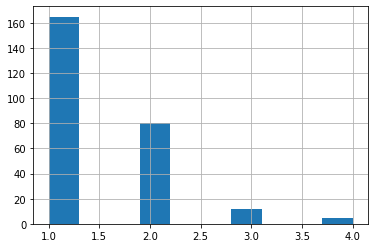

In [120]:
df_clean.traveltime.hist()

Признака содержит значения от 1 до 4. Тех, кто выбирает школу рядом с домом большинство. Не похоже, чтобы в данном столбце были выбросы.

## studytime

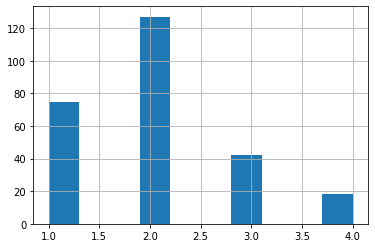

In [121]:
df_clean.studytime.hist()

Содержит значения от 1 до 4. Никаких неожиданностей. Лентяев обычно больше, чем зубрил.

## failures

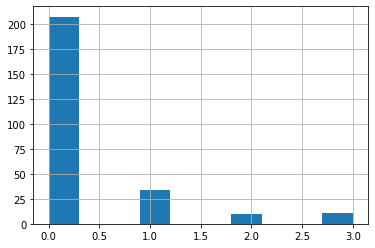

In [122]:
df_clean.failures.hist()

Тут также без неожиданных значений.

## studytime, granular

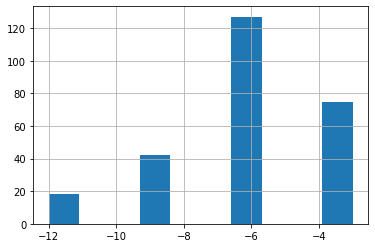

In [123]:
df_clean['studytime, granular'].hist()

Об этом признаке в датасете не сказано ни слова. Вероятно, он попал сюда по ошибке и подлежит удалению, чтобы не создавать лишний шум для нашей модели.

In [124]:
del df_clean['studytime, granular']

## famrel

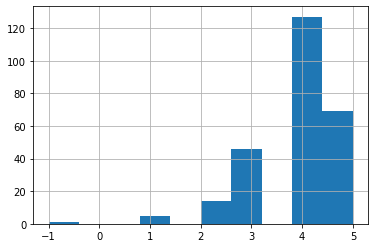

In [125]:
df_clean.famrel.hist()

Данные столбец должен содержать значения от 1 до 5. Отрицательное значение - явный выброс. Удалим его.

In [126]:
df_clean = df_clean[df_clean.famrel >0]

## freetime

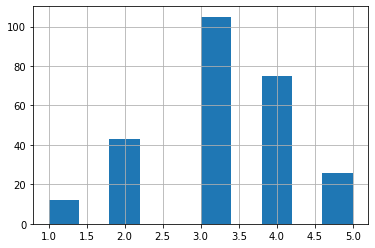

In [127]:
df_clean.freetime.hist()

В данном поле выбросов нет. Содержит исключительно значения от 1 до 5.

## goout

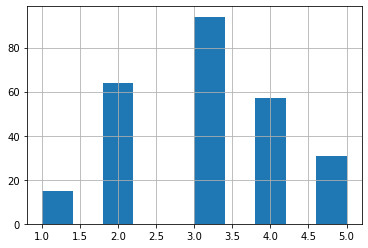

In [128]:
df_clean.goout.hist()

В данном поле выбросов нет. Содержит исключительно значения от 1 до 5.

## health

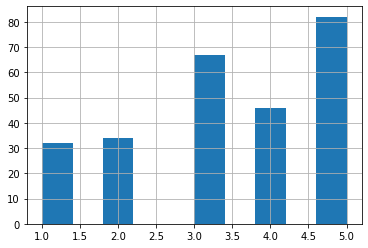

In [129]:
df_clean.health.hist()

В данном поле выбросов нет. Содержит исключительно значения от 1 до 5. Больше значений, близких к пятёрке - у школьников здоровье намного луше, чем у взрослых и пожилых людей.

## absences

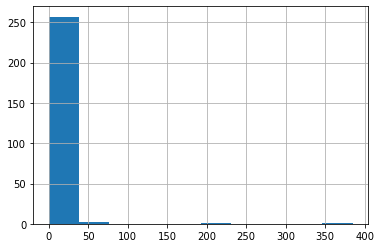

In [130]:
df_clean.absences.hist()

Не похоже, чтобы ученик смог пропустить так много занятий (200 и более). Удалим подозрительные значения.

In [131]:
df_clean = df_clean[df_clean.absences < 200]

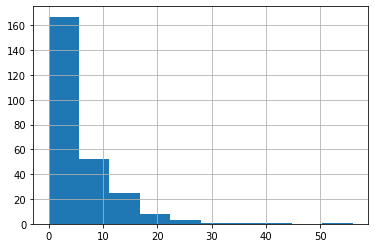

In [132]:
df_clean.absences.hist()

## score

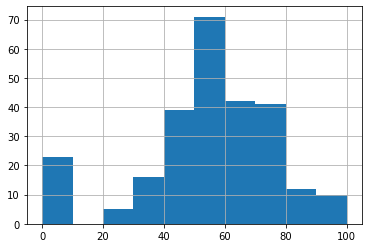

In [133]:
df_clean.score.hist()

Выбросов нет - все значения в диапазоне от 0 до 100. Судя по всему, баллы ставят с шагом 5.

# Корреляционный анализ количественных признаков

In [134]:
df_clean.corr().score

age          -0.135576
Medu          0.164059
Fedu          0.079528
traveltime   -0.040626
studytime     0.072613
failures     -0.322996
famrel        0.015341
freetime      0.033334
goout        -0.159562
health       -0.024345
absences      0.052256
score         1.000000
Name: score, dtype: float64

Поскольку у меня отсутствует опыт фильтрации признаков и мне не известны пороговые значения для принятия решении об удалении, то предположу, что следует удалить признаки с уровнем корреляции менее 5%.


In [135]:
df_corr = df_clean.corr().score.reset_index()
columns_to_del = df_corr[(df_corr.score < 0.05) & (df_corr.score > -0.05)]['index'].to_list()
for column in columns_to_del:
    del df_clean[column]

# Анализ номинальных признаков

Для начала соберём в список все номинальне признаков, которые мы будем анализировать

In [136]:
nom_list = []
for column in df_clean.columns:
    if df[column].dtype == 'O':
        nom_list.append(column)

In [137]:
def get_boxplot(df,column):
    fig, ax = plt.subplots(figsize = (14, 4))
    data = df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])]
    sns.boxplot(x=column, y='score', data= data,ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

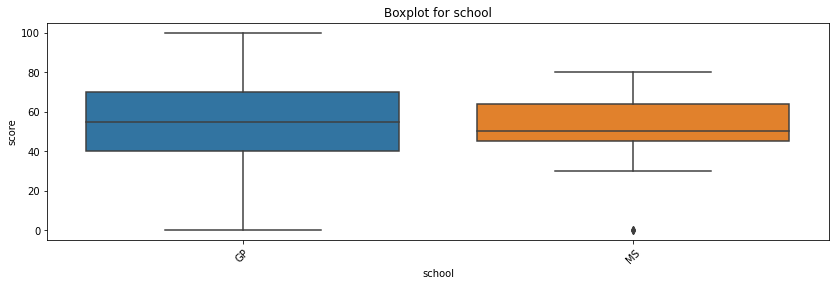

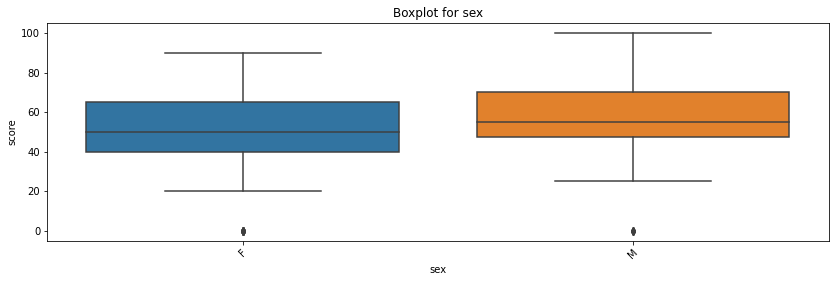

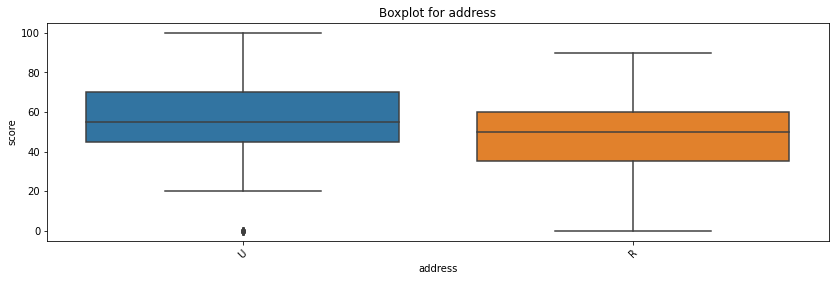

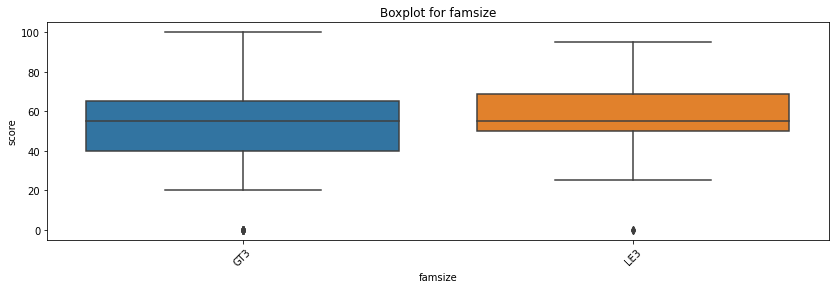

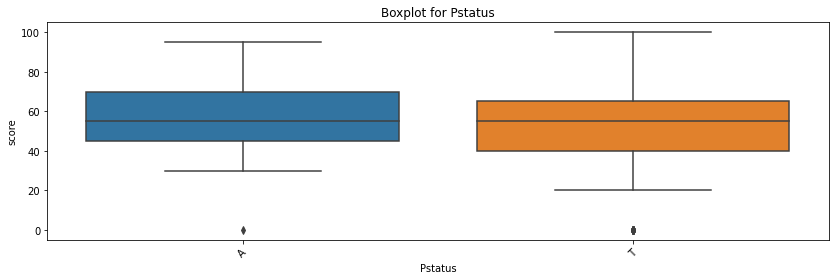

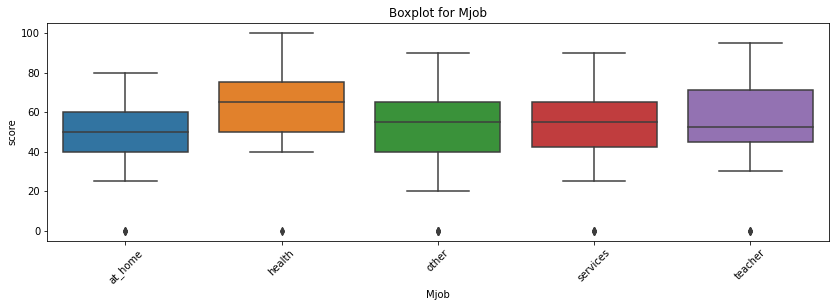

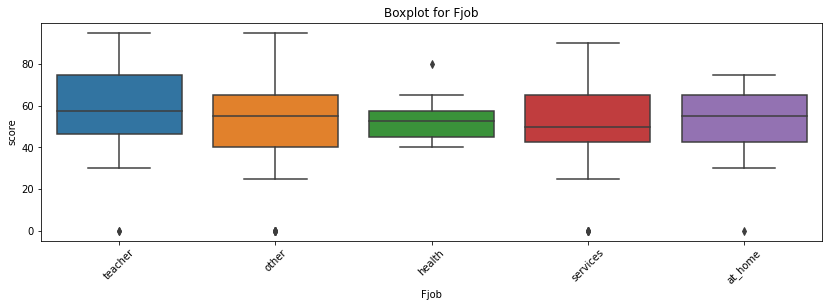

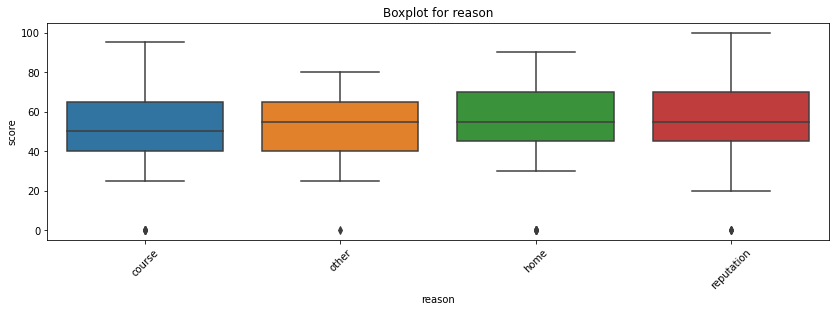

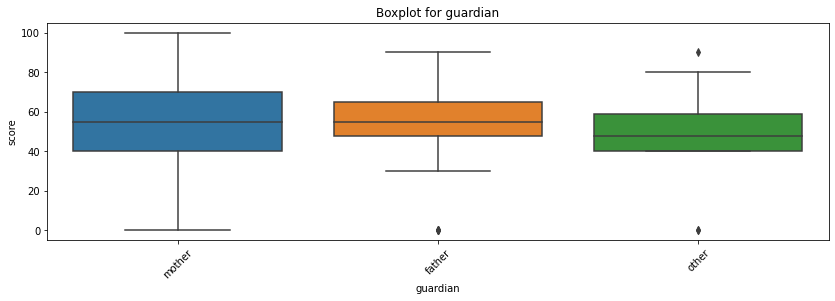

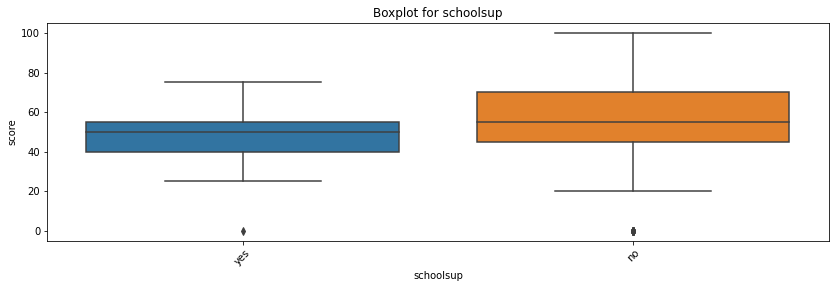

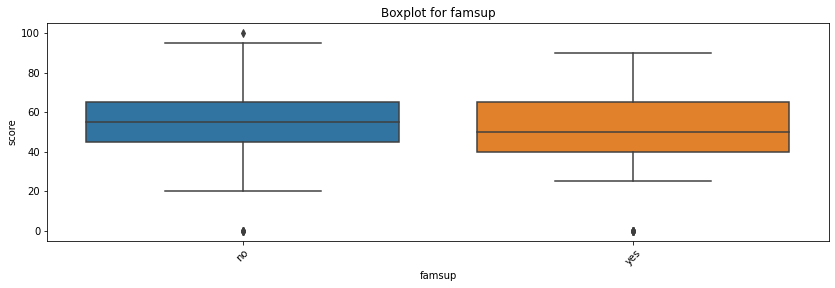

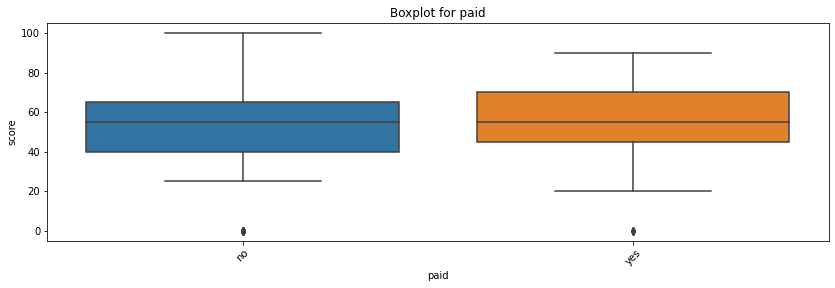

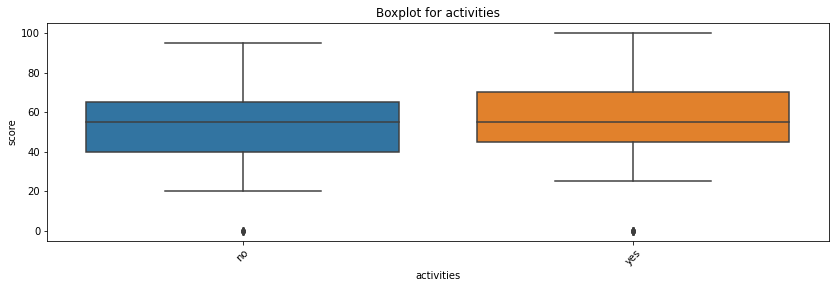

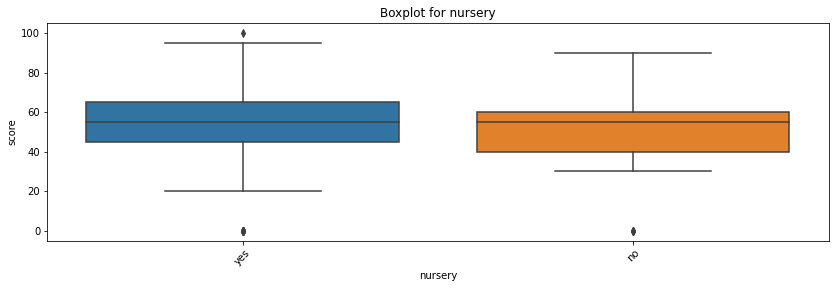

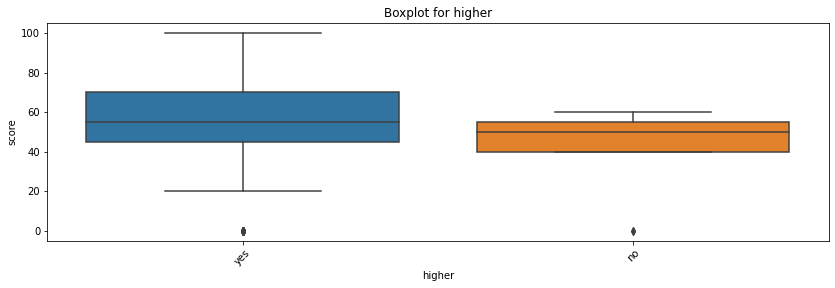

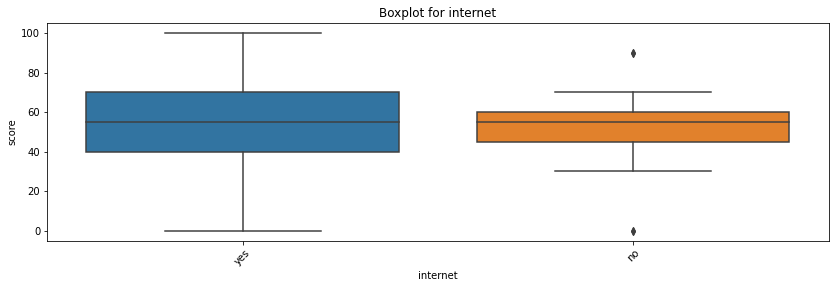

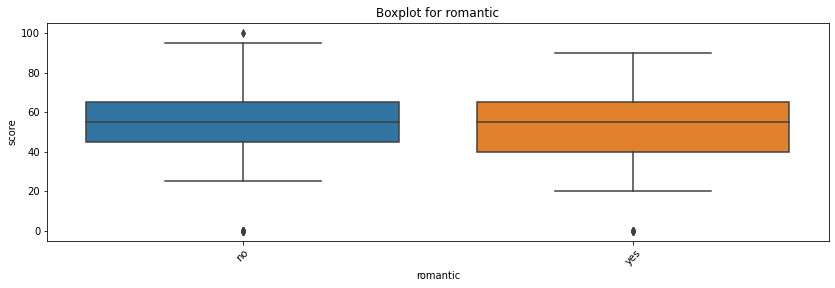

In [138]:
for column in nom_list:
    get_boxplot(df_clean,column)

Взгянув на графики нельзя сказать, что какой-то из признаков совсем не влияет на оценку по математике и подлежит удалению. Попробуем проверить значимость влияния этих признаков на оценку с помощью теста Стьюдента.
Модифицировал функцию, чтобы она возвращала истину, в том случае, если найдены статистически значимые различия, и ложь в противном случае.
Это поможет нам собрать итоговый список колонок для удаления.

In [144]:
def get_stat_dif(df,column):
    ret = False
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            ret = True
            break
    else:
        return False
    return ret
    
columns_to_del = []                      
for col in nom_list:
    if not get_stat_dif(df_clean, col):
        columns_to_del.append(col)


Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки famsize


['school',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

Удаляем соответствующие номинальные признаки из датасета

In [145]:
for column in columns_to_del:
    del df_clean[column]

Теперь можно осталось удалить пустые значения в датасете и он полностью очищен.

In [149]:
df_clean.dropna()

,age,Medu,Fedu,studytime,failures,goout,absences,score
age,1.000000,-0.157099,-0.147344,-0.056321,0.183187,0.084453,0.144329,-0.135576
Medu,-0.157099,1.000000,0.635277,0.078026,-0.193920,0.058690,0.132228,0.164059
Fedu,-0.147344,0.635277,1.000000,0.002937,-0.243628,0.010164,0.086711,0.079528
studytime,-0.056321,0.078026,0.002937,1.000000,-0.131957,-0.111676,-0.054381,0.072613
failures,0.183187,-0.193920,-0.243628,-0.131957,1.000000,0.062441,0.098522,-0.322996
goout,0.084453,0.058690,0.010164,-0.111676,0.062441,1.000000,0.111338,-0.159562
absences,0.144329,0.132228,0.086711,-0.054381,0.098522,0.111338,1.000000,0.052256
score,-0.135576,0.164059,0.079528,0.072613,-0.322996,-0.159562,0.052256,1.000000


# Выводы

Самый полезный вывод, который я для себя сделал - не стоит пользоваться функцией dropna() до тех пор, пока не произвёл корреляционный анализ - это позволяет по максимуму сохранить данные в датасете.

Поскольку мне неизвестна истинная природа данных, то я не стал очищать данные, выходящие за пределы полтора межквартильных расстояния, дабы не потерять полезные данные.

В данном датасете осталось лишь три значимых категориальных признака, а это значит, что мы существенно сократили количество итоговых колонок для обучения, после после вызова функции get_dummies().



Самые значимые количественные признаки - это: failures,Medu,goout,age

